<a href="https://colab.research.google.com/github/kenza-amira/Head_Motion_Classify/blob/main/Scikit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [3]:
cd /content/drive/MyDrive/UG4_Data

/content/drive/MyDrive/UG4_Data


In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid', palette='pastel')
plt.rc('font', family='serif')
from sklearn.cluster import KMeans

# Training KMeans on all y_s

In [5]:
arr = np.load('all_ys.npz')
all_ys = arr["arr_0"]

In [59]:
wcss=[]
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
  kmeans.fit(all_ys)
  wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()
plt.savefig(
    "Elbow_all", 
    bbox_inches="tight"
    )

KeyboardInterrupt: ignored

In [60]:
import pickle
kmeans = pickle.load(open("/content/drive/MyDrive/UG4_Data/kmeans_on_all", "rb"))

In [61]:
# kmeans = KMeans(n_clusters=4, init = 'k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(all_ys)

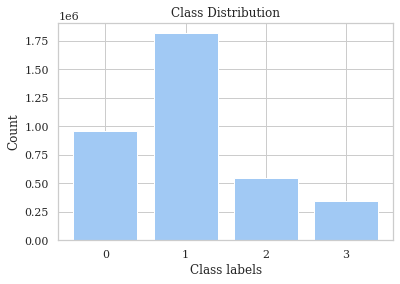

<Figure size 432x288 with 0 Axes>

In [63]:
classes = np.unique(y_kmeans)
counts = np.unique(y_kmeans, return_counts=True)[1]
plt.bar(classes, counts)
plt.xlabel("Class labels")
plt.xticks(classes)
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()
plt.savefig(
    "Class_distrib_all", 
    bbox_inches="tight"
    )

# Average then perdict Scikit

In [73]:
arr = np.load('most_class.npz')
X = arr["arr_0"]
y = arr["arr_1"]
X.shape, y.shape

((6341,), (6341,))

In [75]:
new_y = y

/content/drive/MyDrive/UG4_Data/MOST


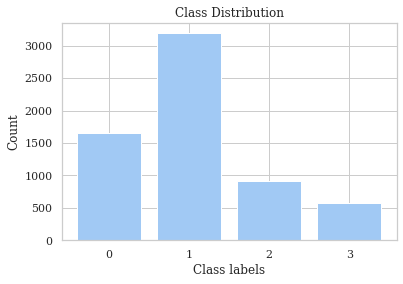

<Figure size 432x288 with 0 Axes>

In [79]:
classes = np.unique(new_y)
counts = np.unique(new_y, return_counts=True)[1]
plt.bar(classes, counts)
plt.xlabel("Class labels")
plt.xticks(classes)
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()
plt.savefig(
    "Class_distrib_most", 
    bbox_inches="tight"
    )

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(X).toarray()
labels = new_y
features.shape

(6341, 1053)

In [81]:
from sklearn.feature_selection import chi2
N = 2
with open("bigram_unigram_most.txt", "w") as out:
    for category_id in classes:
        features_chi2 = chi2(features, labels == category_id)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(tfidf.get_feature_names_out())[indices]
        unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
        bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
        out.write("# '{}':".format(category_id))
        out.write("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
        out.write("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import pandas as pd

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(C=4),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=300),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='balanced_accuracy', cv=CV, groups=labels)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'balanced_accuracy'])
cv_df.to_csv('models_testing_most.csv', index = False)

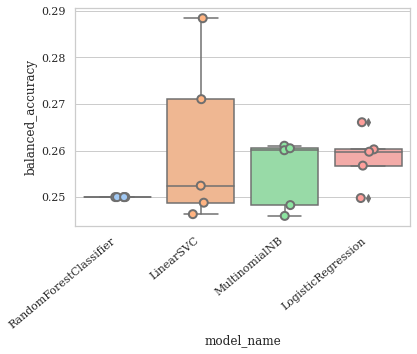

<Figure size 432x288 with 0 Axes>

In [83]:
sns.boxplot(x='model_name', y='balanced_accuracy', data=cv_df)
ax = sns.stripplot(x='model_name', y='balanced_accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha = 'right')
plt.show()
plt.savefig(
    "Box_plot_most"
    )

In [84]:
means = cv_df.groupby('model_name').balanced_accuracy.mean()
means.to_csv("models_grouped_by_mean_most", index = False)
means

model_name
LinearSVC                 0.261411
LogisticRegression        0.258530
MultinomialNB             0.255167
RandomForestClassifier    0.250000
Name: balanced_accuracy, dtype: float64

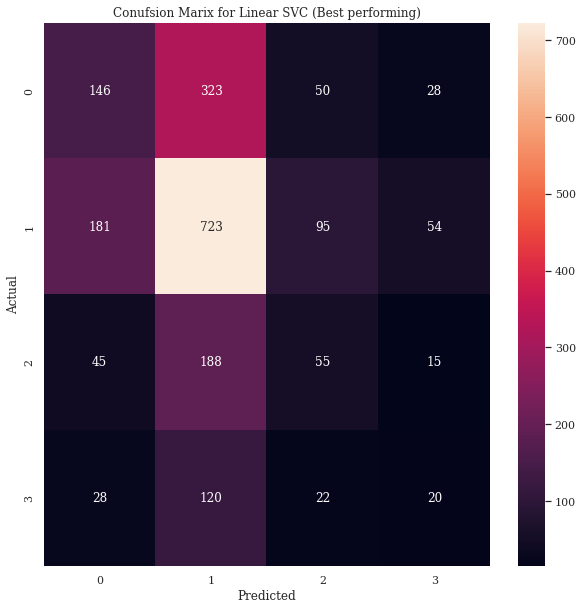

<Figure size 432x288 with 0 Axes>

In [85]:
from sklearn.model_selection import train_test_split
model = LinearSVC(C=4)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, range(0,len(X)), test_size=0.33, random_state=0, stratify=labels)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Conufsion Marix for Linear SVC (Best performing)')
plt.show()
plt.savefig(
    "Best_model_conf"
    )

In [87]:
from sklearn import metrics
report = metrics.classification_report(y_test, y_pred, output_dict=True)
dataframe = pd.DataFrame.from_dict(report)
dataframe.to_csv('classification_report_most.csv', index = False)
dataframe

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.365000,0.533973,0.247748,0.170940,0.451027,0.329415,0.415421
recall,0.266910,0.686610,0.181518,0.105263,0.451027,0.310075,0.451027
f1-score,0.308342,0.600748,0.209524,0.130293,0.451027,0.312227,0.424984
support,547.000000,1053.000000,303.000000,190.000000,0.451027,2093.000000,2093.000000


In [56]:
import pickle
pickle.dump(kmeans, open("kmeans_on_all", 'wb'))